> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, estimate the parameters.

> We select the last 32 time steps of a 32 x 32 grid of a solution of ASDM. The Training dataset includes all grid's data point.

> The free parameters of the model are fixed.

> The goal here is overfitting the model to re-create the exact output from the mtrained model. Therefore, we can be sure about the code and the selected architecture.

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time

GPU = False
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s, layers): 
        
        
        with tf.device(txt_device):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_a", 
                                   constraint= lambda z: tf.clip_by_value(z, 1e-6, 1e10))#tf.constant(0.005, dtype=tf.float32)#
            self.D_s = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_s",
                                  constraint= lambda z: tf.clip_by_value(z, 1e-6, 1e10))#tf.constant(0.2, dtype=tf.float32)#
            self.sigma_a = tf.Variable([0.0], dtype=tf.float32,
                                      name="sigma_a",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.0, dtype=tf.float32, name="sigma_a")#
            self.sigma_s = tf.Variable([1.00], dtype=tf.float32, 
                                       name="sigma_s",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.mu_a = tf.Variable([1.00], dtype=tf.float32, 
                                    name="mu_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_a = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_a",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_s = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_s",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.kappa_a = tf.Variable([1.00], dtype=tf.float32,
                                       name="kappa_a",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.25, dtype=tf.float32)##

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

        self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
        self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")

        self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred = self.net_ASDM(self.x_tf, self.y_tf, self.t_tf)

        self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                    tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

        self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

        self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")
        

        self.loss_init = self.loss_1 
        
        self.loss = self.loss_1 + self.loss_a + self.loss_s     

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        self.train_op_init_Adam = self.optimizer_Adam.minimize(self.loss_init)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
        
        a_t = tf.gradients(a, t)[0]
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        
        s_t = tf.gradients(s, t)[0]
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        
        f = a*a*s/(1 + kappa_a*a*a)
        f_a = a_t - (a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - (s_xx + s_yy) + rho_s*f - sigma_s
        
        return a, s, f_a, f_s
    
    def callback(self, loss, loss_a, loss_s, D_a, D_s, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss.tolist()}, loss_a: {loss_a.tolist()}, loss_s: {loss_s.tolist()},\n"
              f"D_a: {D_a.tolist()}, D_s: {D_s.tolist()}\n"
              f"sigma_a: {sigma_a.tolist()}, sigma_s: {sigma_s.tolist()}\n"
              f"rho_a: {rho_a.tolist()}, rho_s: {rho_s.tolist()}\n"
              f"mu_a: {mu_a.tolist()}, kappa_a: {kappa_a.tolist()}\n")
        
      
    def train_batch(self, nIter, batch_size, use_init= True, early_stop_thresh = None, print_iter = 100):
        
        data_n = self.x.shape[0]
        batch_steps = data_n//batch_size
        batch_steps = batch_steps + (data_n-1)//(batch_steps*batch_size)
        
        data = np.concatenate([self.x, self.y, self.t, self.a, self.s], 1)
        indices = np.array(list(range(data_n)))
        
        arr_total_loss = np.zeros(nIter)
        arr_total_loss_a = np.zeros(nIter)
        arr_total_loss_s = np.zeros(nIter)
        
        arr_D_a = np.zeros(nIter)
        arr_D_s = np.zeros(nIter)
        arr_sigma_a = np.zeros(nIter)
        arr_sigma_s = np.zeros(nIter)
        arr_rho_a = np.zeros(nIter)
        arr_rho_s = np.zeros(nIter)
        arr_mu_a = np.zeros(nIter)
        arr_kappa_a = np.zeros(nIter)
        
        def _get_val(item):
            val = item.tolist()
            if type(val) is float:
                return val
            else:
                return val[0]
        

        
        
        start_time = time.time()
        for it in range(nIter):
            # Shuflle the batches in each epoch
            np.random.shuffle(indices)                        
            total_loss = 0
            total_loss_a = 0
            total_loss_s = 0
            
            for batch in range(batch_steps):
                start = batch*batch_size
                end = (batch+1)*batch_size
                end = end - (end//data_n)*(end%data_n)
                
                batch_indices = indices[start:end]
                
                tf_dict = {self.x_tf: data[batch_indices, 0:1], 
                           self.y_tf: data[batch_indices, 1:2], 
                           self.t_tf: data[batch_indices, 2:3],
                           self.a_tf: data[batch_indices, 3:4], 
                           self.s_tf: data[batch_indices, 4:5]}
                
                if use_init:
                    self.sess.run(self.train_op_init_Adam, tf_dict)
                    loss_value = _get_val(self.sess.run(self.loss_init, tf_dict))
                    loss_a_value = _get_val(self.sess.run(self.loss_a, tf_dict))
                    loss_s_value = _get_val(self.sess.run(self.loss_s, tf_dict))
                else:
                    self.sess.run(self.train_op_Adam, tf_dict)
            
                    loss_value = _get_val(self.sess.run(self.loss, tf_dict))
                    loss_a_value = _get_val(self.sess.run(self.loss_a, tf_dict))
                    loss_s_value = _get_val(self.sess.run(self.loss_s, tf_dict))
                
                total_loss += loss_value
                total_loss_a += loss_a_value
                total_loss_s += loss_s_value
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time                
                D_a_value = _get_val(self.sess.run(self.D_a))
                D_s_value = _get_val(self.sess.run(self.D_s))             
                sigma_a_value = _get_val(self.sess.run(self.sigma_a))
                sigma_s_value = _get_val(self.sess.run(self.sigma_s))              
                rho_a_value = _get_val(self.sess.run(self.rho_a))
                rho_s_value = _get_val(self.sess.run(self.rho_s))
                mu_a_value = _get_val(self.sess.run(self.mu_a))
                kappa_a_value = _get_val(self.sess.run(self.kappa_a))
                
                
                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss:.2f},\n"
                      f"D_a: {D_a_value:.8f}, D_s: {D_s_value:.8f}\n"
                      f"sigma_a: {sigma_a_value:.8f}, sigma_s: {sigma_s_value:.8f}\n"
                      f"rho_a: {rho_a_value:.8f}, rho_s: {rho_s_value:.8f}\n"
                      f"mu_a: {mu_a_value:.8f}, kappa_a: {kappa_a_value:.8f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
            # early stop
            if early_stop_thresh is not None and early_stop_thresh >= total_loss:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time                    
                D_a_value = _get_val(self.sess.run(self.D_a))
                D_s_value = _get_val(self.sess.run(self.D_s))             
                sigma_a_value = _get_val(self.sess.run(self.sigma_a))
                sigma_s_value = _get_val(self.sess.run(self.sigma_s))              
                rho_a_value = _get_val(self.sess.run(self.rho_a))
                rho_s_value = _get_val(self.sess.run(self.rho_s))
                mu_a_value = _get_val(self.sess.run(self.mu_a))
                kappa_a_value = _get_val(self.sess.run(self.kappa_a))
                
                
                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss:.2f},\n"
                      f"D_a: {D_a_value:.8f}, D_s: {D_s_value:.8f}\n"
                      f"sigma_a: {sigma_a_value:.8f}, sigma_s: {sigma_s_value:.8f}\n"
                      f"rho_a: {rho_a_value:.8f}, rho_s: {rho_s_value:.8f}\n"
                      f"mu_a: {mu_a_value:.8f}, kappa_a: {kappa_a_value:.8f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
                arr_total_loss[it] = total_loss
                arr_total_loss_a[it] = total_loss_a
                arr_total_loss_s[it] = total_loss_s
                arr_D_a[it] = D_a_value
                arr_D_s[it] = D_s_value                
                arr_sigma_a[it] = sigma_a_value
                arr_sigma_s[it] = sigma_s_value
                arr_rho_a[it] = rho_a_value
                arr_rho_s[it] = rho_s_value
                arr_mu_a[it] = mu_a_value
                arr_kappa_a[it] = kappa_a_value                
                                
                params = {'D_a': arr_D_a[:(it+1)], 'D_s': arr_D_s[:(it+1)],
                          'sigma_a': arr_sigma_a[:(it+1)] , 'sigma_s': arr_sigma_s[:(it+1)],
                          'rho_a' : arr_rho_a[:(it+1)], 'rho_s' : arr_rho_s[:(it+1)],
                          'mu_a': arr_mu_a[:(it+1)], 'kappa_a': arr_kappa_a[:(it+1)]}
                
                return (arr_total_loss[:(it+1)], 
                        arr_total_loss_a[:(it+1)], 
                        arr_total_loss_s[:(it+1)], 
                        params)    
        
            arr_total_loss[it] = total_loss
            arr_total_loss_a[it] = total_loss_a
            arr_total_loss_s[it] = total_loss_s
            arr_D_a[it] = D_a_value
            arr_D_s[it] = D_s_value            
            arr_sigma_a[it] = sigma_a_value
            arr_sigma_s[it] = sigma_s_value
            arr_rho_a[it] = rho_a_value
            arr_rho_s[it] = rho_s_value
            arr_mu_a[it] = mu_a_value
            arr_kappa_a[it] = kappa_a_value
            
        # end for it
        params = {'D_a': arr_D_a, 'D_s': arr_D_s,
                  'sigma_a': arr_sigma_a , 'sigma_s': arr_sigma_s,
                  'rho_a' : arr_rho_a, 'rho_s' : arr_rho_s, 'mu_a': arr_mu_a, 'kappa_a': arr_kappa_a}
        return (arr_total_loss, 
                arr_total_loss_a, 
                arr_total_loss_s, 
                params)
                
            
        
        
    def minimise(self, max_iter = None, f_tol = None):
        if max_iter is not None:
            self.optimizer.optimizer_kwargs['options']['maxiter'] = max_iter
            
        if f_tol is not None:
            self.optimizer.optimizer_kwargs['options']['f_tol'] = f_tol
        
        
        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_a, self.loss_s,
                                           self.D_a, self.D_s,
                                          self.sigma_a, self.sigma_s,
                                          self.rho_a, self.rho_s,
                                          self.mu_a, self.kappa_a],
                                loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [3]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = 32#10#t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
# 32 worked
#idx = np.random.choice(N*T, T*32, replace=False)
idx = np.random.choice(N*T, T*16, replace=False)
#idx = list(range(N*T))
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:]
s_train = s[idx,:]




In [4]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, layers)
loss, loss_a, loss_s,  params_estimates = \
model.train_batch(50000, batch_size=len(idx)//16, use_init=False, early_stop_thresh=0.01, print_iter=50)

It: 0, loss_a  : 15.23676181, loss_s  : 486.09076881, loss  : 1620.38,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.01269007, sigma_s: 0.98403746
rho_a: 1.01034236, rho_s: 1.00817442
mu_a: 0.98452318, kappa_a: 0.99270284, 
Time:2.69

It: 50, loss_a  : 0.58363460, loss_s  : 0.98985287, loss  : 151.10,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.09423304, sigma_s: 0.88243580
rho_a: 1.11189377, rho_s: 1.23048747
mu_a: 0.87891203, kappa_a: 0.78770322, 
Time:7.35

It: 100, loss_a  : 0.30503124, loss_s  : 0.72231184, loss  : 149.27,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.09122077, sigma_s: 0.87057310
rho_a: 1.10466576, rho_s: 1.22789204
mu_a: 0.87074202, kappa_a: 0.80793941, 
Time:7.29

It: 150, loss_a  : 0.09999711, loss_s  : 0.30665325, loss  : 148.37,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.08769325, sigma_s: 0.85596281
rho_a: 1.10086656, rho_s: 1.22444654
mu_a: 0.85680783, kappa_a: 0.82813871, 
Time:7.30

It: 200, loss_a  : 0.14916278, loss_s  : 0.26511252, loss  : 148.50,
D_a: 1

It: 1800, loss_a  : 0.02612367, loss_s  : 0.00812287, loss  : 145.03,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.10985647
rho_a: 0.31889090, rho_s: 0.24774796
mu_a: 0.13973488, kappa_a: 1.87327373, 
Time:7.28

It: 1850, loss_a  : 0.04040008, loss_s  : 0.01224130, loss  : 146.51,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08897650
rho_a: 0.24986131, rho_s: 0.20755635
mu_a: 0.11448317, kappa_a: 1.89728844, 
Time:7.30

It: 1900, loss_a  : 0.01181962, loss_s  : 0.00531055, loss  : 145.06,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00125359, sigma_s: 0.07464363
rho_a: 0.19945154, rho_s: 0.17095393
mu_a: 0.08460159, kappa_a: 1.91459453, 
Time:7.28

It: 1950, loss_a  : 0.00720089, loss_s  : 0.00336747, loss  : 145.03,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.06142995
rho_a: 0.14189027, rho_s: 0.13759540
mu_a: 0.06217800, kappa_a: 1.93621111, 
Time:7.32

It: 2000, loss_a  : 0.00328570, loss_s  : 0.00193455, loss  : 144.98,
D_

It: 3600, loss_a  : 0.07500062, loss_s  : 0.00378732, loss  : 132.62,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02184217
rho_a: 0.00139704, rho_s: 0.04522770
mu_a: 0.00000000, kappa_a: 1.70413208, 
Time:7.34

It: 3650, loss_a  : 0.08182632, loss_s  : 0.00430208, loss  : 132.17,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02200470
rho_a: 0.00178730, rho_s: 0.04615249
mu_a: 0.00000000, kappa_a: 1.67569315, 
Time:7.30

It: 3700, loss_a  : 0.09885653, loss_s  : 0.00443321, loss  : 131.08,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02245992
rho_a: 0.00153665, rho_s: 0.04895437
mu_a: 0.00000000, kappa_a: 1.64654887, 
Time:7.34

It: 3750, loss_a  : 0.11382912, loss_s  : 0.00486064, loss  : 130.95,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02526647
rho_a: 0.00199009, rho_s: 0.05027315
mu_a: 0.00000000, kappa_a: 1.61787176, 
Time:7.33

It: 3800, loss_a  : 0.13901387, loss_s  : 0.00655774, loss  : 130.03,
D_

It: 5400, loss_a  : 3.38062985, loss_s  : 0.30846934, loss  : 24.50,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04843892
rho_a: 0.58162135, rho_s: 0.04164324
mu_a: 0.65983832, kappa_a: 0.15302190, 
Time:7.36

It: 5450, loss_a  : 2.99413448, loss_s  : 0.30177009, loss  : 21.41,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04963221
rho_a: 0.60958087, rho_s: 0.04300576
mu_a: 0.68342870, kappa_a: 0.15849604, 
Time:7.32

It: 5500, loss_a  : 3.02563344, loss_s  : 0.30058444, loss  : 19.89,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.05028786
rho_a: 0.63583916, rho_s: 0.04280574
mu_a: 0.71079355, kappa_a: 0.16092560, 
Time:7.33

It: 5550, loss_a  : 2.81122887, loss_s  : 0.28929348, loss  : 17.64,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.05118466
rho_a: 0.66059691, rho_s: 0.04452191
mu_a: 0.73419321, kappa_a: 0.16445160, 
Time:7.30

It: 5600, loss_a  : 2.58380019, loss_s  : 0.27121697, loss  : 15.95,
D_a: 1.

It: 7200, loss_a  : 0.63113371, loss_s  : 0.09058505, loss  : 3.17,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.05878409
rho_a: 0.87352383, rho_s: 0.05514031
mu_a: 0.94037944, kappa_a: 0.18958706, 
Time:7.30

It: 7250, loss_a  : 0.62871883, loss_s  : 0.08972125, loss  : 2.85,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.05806313
rho_a: 0.87371850, rho_s: 0.05445671
mu_a: 0.93897605, kappa_a: 0.19114678, 
Time:7.31

It: 7300, loss_a  : 0.58024676, loss_s  : 0.08868553, loss  : 2.75,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.05744343
rho_a: 0.87433940, rho_s: 0.05468512
mu_a: 0.93876588, kappa_a: 0.19056185, 
Time:7.33

It: 7350, loss_a  : 0.52961588, loss_s  : 0.07833712, loss  : 2.63,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.05772555
rho_a: 0.87364012, rho_s: 0.05538142
mu_a: 0.93832839, kappa_a: 0.19127420, 
Time:7.32

It: 7400, loss_a  : 0.56192829, loss_s  : 0.08181143, loss  : 2.51,
D_a: 1.00000

It: 9000, loss_a  : 0.18705264, loss_s  : 0.05301859, loss  : 0.77,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.05759712
rho_a: 0.86610031, rho_s: 0.05570088
mu_a: 0.92938077, kappa_a: 0.18445922, 
Time:7.30

It: 9050, loss_a  : 0.22514749, loss_s  : 0.05079599, loss  : 0.91,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00013167, sigma_s: 0.05646889
rho_a: 0.86438167, rho_s: 0.05506595
mu_a: 0.92897350, kappa_a: 0.18410605, 
Time:7.30

It: 9100, loss_a  : 0.18692838, loss_s  : 0.05125224, loss  : 0.99,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000785, sigma_s: 0.05651645
rho_a: 0.86285561, rho_s: 0.05536190
mu_a: 0.92673254, kappa_a: 0.18497756, 
Time:7.32

It: 9150, loss_a  : 0.42534054, loss_s  : 0.06520191, loss  : 1.79,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.05678611
rho_a: 0.86304361, rho_s: 0.05617163
mu_a: 0.92871696, kappa_a: 0.18535358, 
Time:7.33

It: 9200, loss_a  : 0.24638284, loss_s  : 0.05545765, loss  : 1.11,
D_a: 1.00000

It: 10800, loss_a  : 0.05853468, loss_s  : 0.03762101, loss  : 0.27,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00009038, sigma_s: 0.05448528
rho_a: 0.82805848, rho_s: 0.05457858
mu_a: 0.89546096, kappa_a: 0.17719319, 
Time:7.32

It: 10850, loss_a  : 0.06588950, loss_s  : 0.03850809, loss  : 0.30,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.05385979
rho_a: 0.82580352, rho_s: 0.05550132
mu_a: 0.89299816, kappa_a: 0.17700469, 
Time:7.33

It: 10900, loss_a  : 0.21438076, loss_s  : 0.05269967, loss  : 1.02,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00037602, sigma_s: 0.05502540
rho_a: 0.82428634, rho_s: 0.05307075
mu_a: 0.89298159, kappa_a: 0.17767631, 
Time:7.32

It: 10950, loss_a  : 0.25702791, loss_s  : 0.05162887, loss  : 1.09,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.05571343
rho_a: 0.82451582, rho_s: 0.05493997
mu_a: 0.89002842, kappa_a: 0.17872857, 
Time:7.33

It: 11000, loss_a  : 0.13964211, loss_s  : 0.04266004, loss  : 0.61,
D_a: 1.

It: 12600, loss_a  : 0.21451034, loss_s  : 0.04701027, loss  : 0.86,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.05194647
rho_a: 0.79310775, rho_s: 0.05367142
mu_a: 0.85462821, kappa_a: 0.18135129, 
Time:7.31

It: 12650, loss_a  : 0.15637083, loss_s  : 0.04124015, loss  : 0.74,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00021958, sigma_s: 0.05213535
rho_a: 0.79275054, rho_s: 0.05214897
mu_a: 0.85413939, kappa_a: 0.17943309, 
Time:7.33

It: 12700, loss_a  : 0.06734166, loss_s  : 0.03560799, loss  : 0.32,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00007424, sigma_s: 0.05188009
rho_a: 0.79242575, rho_s: 0.05276516
mu_a: 0.85262233, kappa_a: 0.17846809, 
Time:7.33

It: 12750, loss_a  : 0.17575740, loss_s  : 0.04302564, loss  : 0.85,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.05116353
rho_a: 0.79234749, rho_s: 0.05203106
mu_a: 0.85013598, kappa_a: 0.18060826, 
Time:7.32

It: 12800, loss_a  : 0.10292700, loss_s  : 0.03724233, loss  : 0.46,
D_a: 1.

It: 14400, loss_a  : 0.07424808, loss_s  : 0.03203633, loss  : 0.35,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04903244
rho_a: 0.76049107, rho_s: 0.05138088
mu_a: 0.81148934, kappa_a: 0.18243194, 
Time:7.30

It: 14450, loss_a  : 0.20371772, loss_s  : 0.03564500, loss  : 0.69,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00042666, sigma_s: 0.04979809
rho_a: 0.76039428, rho_s: 0.05071918
mu_a: 0.81018090, kappa_a: 0.18266807, 
Time:7.32

It: 14500, loss_a  : 0.02090028, loss_s  : 0.02628826, loss  : 0.13,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04858240
rho_a: 0.75869370, rho_s: 0.05021141
mu_a: 0.81051731, kappa_a: 0.18249592, 
Time:7.31

It: 14550, loss_a  : 0.32286973, loss_s  : 0.05254915, loss  : 1.35,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00057286, sigma_s: 0.04897837
rho_a: 0.75856984, rho_s: 0.05056436
mu_a: 0.80808252, kappa_a: 0.18299171, 
Time:7.32

It: 14600, loss_a  : 0.09487677, loss_s  : 0.03194498, loss  : 0.37,
D_a: 1.

It: 16200, loss_a  : 0.09789626, loss_s  : 0.02911226, loss  : 0.42,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00008655, sigma_s: 0.04648287
rho_a: 0.72611088, rho_s: 0.04943309
mu_a: 0.77271628, kappa_a: 0.18273227, 
Time:7.33

It: 16250, loss_a  : 0.15792417, loss_s  : 0.03328936, loss  : 0.59,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04895454
rho_a: 0.72594225, rho_s: 0.04907360
mu_a: 0.77120948, kappa_a: 0.18198958, 
Time:7.29

It: 16300, loss_a  : 0.03827668, loss_s  : 0.02423892, loss  : 0.18,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00003782, sigma_s: 0.04644083
rho_a: 0.72331041, rho_s: 0.04957224
mu_a: 0.77059150, kappa_a: 0.18211736, 
Time:7.31

It: 16350, loss_a  : 0.07768303, loss_s  : 0.02998314, loss  : 0.36,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04658021
rho_a: 0.72333491, rho_s: 0.04909180
mu_a: 0.77025467, kappa_a: 0.18186927, 
Time:7.32

It: 16400, loss_a  : 0.02214008, loss_s  : 0.02330282, loss  : 0.12,
D_a: 1.

It: 18000, loss_a  : 0.24628482, loss_s  : 0.04245853, loss  : 0.89,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00086648, sigma_s: 0.04519973
rho_a: 0.69326091, rho_s: 0.04695998
mu_a: 0.73447078, kappa_a: 0.18294606, 
Time:7.29

It: 18050, loss_a  : 0.06536907, loss_s  : 0.02677454, loss  : 0.25,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04486495
rho_a: 0.69247723, rho_s: 0.04690109
mu_a: 0.73368955, kappa_a: 0.18347204, 
Time:7.36

It: 18100, loss_a  : 0.04844295, loss_s  : 0.02452143, loss  : 0.22,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00035219, sigma_s: 0.04477397
rho_a: 0.69206989, rho_s: 0.04672820
mu_a: 0.73205453, kappa_a: 0.18438369, 
Time:7.33

It: 18150, loss_a  : 0.09559481, loss_s  : 0.02823975, loss  : 0.43,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00033567, sigma_s: 0.04511225
rho_a: 0.68963391, rho_s: 0.04513975
mu_a: 0.73109710, kappa_a: 0.18460579, 
Time:7.29

It: 18200, loss_a  : 0.05046103, loss_s  : 0.02305396, loss  : 0.22,
D_a: 1.

It: 19800, loss_a  : 0.02547750, loss_s  : 0.01837465, loss  : 0.11,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00016309, sigma_s: 0.04251863
rho_a: 0.66845995, rho_s: 0.04594140
mu_a: 0.70468527, kappa_a: 0.18704104, 
Time:7.35

It: 19850, loss_a  : 0.03295835, loss_s  : 0.01925077, loss  : 0.16,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04287685
rho_a: 0.66811079, rho_s: 0.04507951
mu_a: 0.70403594, kappa_a: 0.18751082, 
Time:7.35

It: 19900, loss_a  : 0.03896120, loss_s  : 0.01902506, loss  : 0.16,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00008039, sigma_s: 0.04258812
rho_a: 0.66718811, rho_s: 0.04580313
mu_a: 0.70334417, kappa_a: 0.18799214, 
Time:7.34

It: 19950, loss_a  : 0.39207323, loss_s  : 0.04674155, loss  : 1.48,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00005947, sigma_s: 0.04333936
rho_a: 0.66714799, rho_s: 0.04547070
mu_a: 0.70467240, kappa_a: 0.18828772, 
Time:7.33

It: 20000, loss_a  : 0.10903879, loss_s  : 0.02519449, loss  : 0.41,
D_a: 1.

It: 21600, loss_a  : 0.02762526, loss_s  : 0.01663417, loss  : 0.12,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00002343, sigma_s: 0.04105690
rho_a: 0.65371633, rho_s: 0.04419772
mu_a: 0.68472147, kappa_a: 0.19126327, 
Time:7.33

It: 21650, loss_a  : 0.07639587, loss_s  : 0.01975196, loss  : 0.33,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00055657, sigma_s: 0.04046495
rho_a: 0.65238160, rho_s: 0.04376728
mu_a: 0.68406904, kappa_a: 0.19069736, 
Time:7.32

It: 21700, loss_a  : 0.07202954, loss_s  : 0.01938558, loss  : 0.26,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04157994
rho_a: 0.65178895, rho_s: 0.04374295
mu_a: 0.68360120, kappa_a: 0.19123083, 
Time:7.32

It: 21750, loss_a  : 0.01369087, loss_s  : 0.01469322, loss  : 0.06,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04100615
rho_a: 0.65135080, rho_s: 0.04385726
mu_a: 0.68278515, kappa_a: 0.19134158, 
Time:7.33

It: 21800, loss_a  : 0.35898843, loss_s  : 0.05090749, loss  : 1.40,
D_a: 1.

It: 23400, loss_a  : 0.01108536, loss_s  : 0.01341502, loss  : 0.05,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000978, sigma_s: 0.03898011
rho_a: 0.63662428, rho_s: 0.04389626
mu_a: 0.66424614, kappa_a: 0.19354261, 
Time:7.32

It: 23450, loss_a  : 0.06391639, loss_s  : 0.01863784, loss  : 0.26,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04045995
rho_a: 0.63640797, rho_s: 0.04295450
mu_a: 0.66397065, kappa_a: 0.19384897, 
Time:7.30

It: 23500, loss_a  : 0.00693054, loss_s  : 0.01264003, loss  : 0.04,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00003442, sigma_s: 0.03878298
rho_a: 0.63672048, rho_s: 0.04329497
mu_a: 0.66167980, kappa_a: 0.19475104, 
Time:7.30

It: 23550, loss_a  : 0.06421754, loss_s  : 0.01820132, loss  : 0.29,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03936561
rho_a: 0.63628072, rho_s: 0.04312712
mu_a: 0.66141897, kappa_a: 0.19443667, 
Time:7.31

It: 23600, loss_a  : 0.00859907, loss_s  : 0.01295258, loss  : 0.05,
D_a: 1.

It: 25200, loss_a  : 0.27652389, loss_s  : 0.04281648, loss  : 0.88,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04012878
rho_a: 0.63232803, rho_s: 0.04349588
mu_a: 0.66073573, kappa_a: 0.19606057, 
Time:7.34

It: 25250, loss_a  : 0.04884159, loss_s  : 0.01473289, loss  : 0.20,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03875209
rho_a: 0.63334686, rho_s: 0.04223115
mu_a: 0.65941477, kappa_a: 0.19830649, 
Time:7.30

It: 25300, loss_a  : 0.04619607, loss_s  : 0.01557761, loss  : 0.17,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00072669, sigma_s: 0.03844051
rho_a: 0.63368106, rho_s: 0.04227558
mu_a: 0.65773642, kappa_a: 0.19871892, 
Time:7.33

It: 25350, loss_a  : 0.02045545, loss_s  : 0.01232778, loss  : 0.09,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03857963
rho_a: 0.63279843, rho_s: 0.04288679
mu_a: 0.65691900, kappa_a: 0.19746557, 
Time:7.33

It: 25400, loss_a  : 0.02951422, loss_s  : 0.01338613, loss  : 0.12,
D_a: 1.

It: 27000, loss_a  : 0.00733358, loss_s  : 0.01025202, loss  : 0.04,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00017563, sigma_s: 0.03725510
rho_a: 0.61886013, rho_s: 0.04201835
mu_a: 0.64031744, kappa_a: 0.19848385, 
Time:7.36

It: 27050, loss_a  : 0.03879601, loss_s  : 0.01290413, loss  : 0.15,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03807818
rho_a: 0.61733490, rho_s: 0.04163581
mu_a: 0.64003712, kappa_a: 0.19853251, 
Time:7.29

It: 27100, loss_a  : 0.06027640, loss_s  : 0.01442927, loss  : 0.24,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00106716, sigma_s: 0.03673331
rho_a: 0.61733711, rho_s: 0.04146325
mu_a: 0.63912773, kappa_a: 0.19847623, 
Time:7.30

It: 27150, loss_a  : 0.02352280, loss_s  : 0.01182739, loss  : 0.09,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00066583, sigma_s: 0.03695880
rho_a: 0.61706132, rho_s: 0.04224950
mu_a: 0.63858449, kappa_a: 0.19841017, 
Time:7.32

It: 27200, loss_a  : 0.01851840, loss_s  : 0.01092444, loss  : 0.08,
D_a: 1.

It: 28800, loss_a  : 0.16898408, loss_s  : 0.02757339, loss  : 0.70,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03647625
rho_a: 0.60225654, rho_s: 0.04051204
mu_a: 0.62417555, kappa_a: 0.19877391, 
Time:7.32

It: 28850, loss_a  : 0.01793924, loss_s  : 0.01014282, loss  : 0.07,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03655176
rho_a: 0.60181767, rho_s: 0.04068897
mu_a: 0.62069100, kappa_a: 0.19998343, 
Time:7.34

It: 28900, loss_a  : 0.00665551, loss_s  : 0.00973419, loss  : 0.04,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03663895
rho_a: 0.60093492, rho_s: 0.04045986
mu_a: 0.62007487, kappa_a: 0.20116630, 
Time:7.30

It: 28950, loss_a  : 0.09032444, loss_s  : 0.01724088, loss  : 0.30,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00100475, sigma_s: 0.03509326
rho_a: 0.60143328, rho_s: 0.04028604
mu_a: 0.61938411, kappa_a: 0.20228335, 
Time:7.34

It: 29000, loss_a  : 0.13060910, loss_s  : 0.02438195, loss  : 0.45,
D_a: 1.

It: 30600, loss_a  : 0.00369405, loss_s  : 0.00803446, loss  : 0.03,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03565570
rho_a: 0.58960396, rho_s: 0.03963031
mu_a: 0.60702926, kappa_a: 0.20290627, 
Time:7.34

It: 30650, loss_a  : 0.07430459, loss_s  : 0.01575838, loss  : 0.26,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03627785
rho_a: 0.58777183, rho_s: 0.03921653
mu_a: 0.60800040, kappa_a: 0.20207053, 
Time:7.36

It: 30700, loss_a  : 0.01399055, loss_s  : 0.00840069, loss  : 0.05,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03577296
rho_a: 0.58934671, rho_s: 0.03993057
mu_a: 0.60710931, kappa_a: 0.20188731, 
Time:7.35

It: 30750, loss_a  : 0.06699580, loss_s  : 0.01675100, loss  : 0.25,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00016681, sigma_s: 0.03543667
rho_a: 0.58813578, rho_s: 0.03990848
mu_a: 0.60687822, kappa_a: 0.20225804, 
Time:7.34

It: 30800, loss_a  : 0.08902985, loss_s  : 0.01643611, loss  : 0.35,
D_a: 1.

It: 32400, loss_a  : 0.03361442, loss_s  : 0.01051759, loss  : 0.12,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03519692
rho_a: 0.57586020, rho_s: 0.03880613
mu_a: 0.59288424, kappa_a: 0.20147318, 
Time:7.32

It: 32450, loss_a  : 0.01987867, loss_s  : 0.01243594, loss  : 0.07,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00130401, sigma_s: 0.03503631
rho_a: 0.57654101, rho_s: 0.03869543
mu_a: 0.59605801, kappa_a: 0.20045374, 
Time:7.29

It: 32500, loss_a  : 0.00441364, loss_s  : 0.00900534, loss  : 0.03,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00011132, sigma_s: 0.03523979
rho_a: 0.57670820, rho_s: 0.03837549
mu_a: 0.59389061, kappa_a: 0.20159592, 
Time:7.32

It: 32550, loss_a  : 0.03027841, loss_s  : 0.01109099, loss  : 0.11,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00006395, sigma_s: 0.03513941
rho_a: 0.57519376, rho_s: 0.03846788
mu_a: 0.59409136, kappa_a: 0.20116590, 
Time:7.32

It: 32600, loss_a  : 0.10565040, loss_s  : 0.01982090, loss  : 0.35,
D_a: 1.

It: 34200, loss_a  : 0.07973918, loss_s  : 0.02568079, loss  : 0.23,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03526777
rho_a: 0.56240475, rho_s: 0.03727578
mu_a: 0.58412689, kappa_a: 0.19731390, 
Time:7.33

It: 34250, loss_a  : 0.05699914, loss_s  : 0.01854557, loss  : 0.16,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03357434
rho_a: 0.56780887, rho_s: 0.03941038
mu_a: 0.58133107, kappa_a: 0.20306581, 
Time:7.33

It: 34300, loss_a  : 0.02009120, loss_s  : 0.01228390, loss  : 0.08,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03370260
rho_a: 0.57029247, rho_s: 0.03873354
mu_a: 0.58235967, kappa_a: 0.20471939, 
Time:7.36

It: 34350, loss_a  : 0.01373711, loss_s  : 0.01140449, loss  : 0.05,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03456908
rho_a: 0.57033086, rho_s: 0.03779721
mu_a: 0.58594275, kappa_a: 0.20197947, 
Time:7.31

It: 34400, loss_a  : 0.04518404, loss_s  : 0.01177058, loss  : 0.14,
D_a: 1.

It: 36000, loss_a  : 0.01015863, loss_s  : 0.00691609, loss  : 0.05,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03316689
rho_a: 0.55497187, rho_s: 0.03701712
mu_a: 0.57214993, kappa_a: 0.20036685, 
Time:7.33

It: 36050, loss_a  : 0.06023947, loss_s  : 0.01255781, loss  : 0.22,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03263390
rho_a: 0.55405098, rho_s: 0.03668179
mu_a: 0.57181501, kappa_a: 0.20017339, 
Time:7.35

It: 36100, loss_a  : 0.03734768, loss_s  : 0.01028308, loss  : 0.14,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03392425
rho_a: 0.55376405, rho_s: 0.03643605
mu_a: 0.57217330, kappa_a: 0.19927911, 
Time:7.33

It: 36150, loss_a  : 0.09032276, loss_s  : 0.01407060, loss  : 0.29,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03315067
rho_a: 0.55304348, rho_s: 0.03794208
mu_a: 0.57003814, kappa_a: 0.20030764, 
Time:7.37

It: 36200, loss_a  : 0.04401529, loss_s  : 0.01173133, loss  : 0.19,
D_a: 1.

It: 37800, loss_a  : 0.04075345, loss_s  : 0.01120233, loss  : 0.17,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03196439
rho_a: 0.53614038, rho_s: 0.03648185
mu_a: 0.55218363, kappa_a: 0.19884901, 
Time:7.35

It: 37850, loss_a  : 0.00778781, loss_s  : 0.00587457, loss  : 0.03,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03122249
rho_a: 0.53529328, rho_s: 0.03585333
mu_a: 0.55131632, kappa_a: 0.20028478, 
Time:7.34

It: 37900, loss_a  : 0.10677196, loss_s  : 0.01940681, loss  : 0.37,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00117675, sigma_s: 0.03292157
rho_a: 0.53480196, rho_s: 0.03573012
mu_a: 0.55829442, kappa_a: 0.19483931, 
Time:7.31

It: 37950, loss_a  : 0.00222327, loss_s  : 0.00581733, loss  : 0.02,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00006968, sigma_s: 0.03194943
rho_a: 0.53738582, rho_s: 0.03637004
mu_a: 0.55422461, kappa_a: 0.19897558, 
Time:7.33

It: 38000, loss_a  : 0.03071010, loss_s  : 0.00881620, loss  : 0.11,
D_a: 1.

It: 39600, loss_a  : 0.03934867, loss_s  : 0.00960263, loss  : 0.16,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00008145, sigma_s: 0.03070504
rho_a: 0.52178973, rho_s: 0.03510078
mu_a: 0.53512114, kappa_a: 0.20184329, 
Time:7.40

It: 39650, loss_a  : 8.79889548, loss_s  : 0.70118929, loss  : 38.49,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04526395
rho_a: 0.51759613, rho_s: 0.04238462
mu_a: 0.55942512, kappa_a: 0.17405747, 
Time:7.39

It: 39700, loss_a  : 0.51194008, loss_s  : 0.07220368, loss  : 1.44,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03693787
rho_a: 0.53338993, rho_s: 0.03850854
mu_a: 0.56962961, kappa_a: 0.17472996, 
Time:7.38

It: 39750, loss_a  : 0.24898404, loss_s  : 0.05332159, loss  : 0.69,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00053933, sigma_s: 0.03563550
rho_a: 0.54583782, rho_s: 0.03923310
mu_a: 0.57366586, kappa_a: 0.18249819, 
Time:7.35

It: 39800, loss_a  : 0.14195353, loss_s  : 0.03894098, loss  : 0.46,
D_a: 1

It: 41400, loss_a  : 0.02784701, loss_s  : 0.01174418, loss  : 0.11,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00031952, sigma_s: 0.03107385
rho_a: 0.52549541, rho_s: 0.03574797
mu_a: 0.54019994, kappa_a: 0.20169246, 
Time:7.40

It: 41450, loss_a  : 0.04836044, loss_s  : 0.01295384, loss  : 0.18,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00071188, sigma_s: 0.03103110
rho_a: 0.52404898, rho_s: 0.03506063
mu_a: 0.53959632, kappa_a: 0.20149516, 
Time:7.36

It: 41500, loss_a  : 0.04819009, loss_s  : 0.01165395, loss  : 0.19,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03169122
rho_a: 0.52279091, rho_s: 0.03505121
mu_a: 0.53810632, kappa_a: 0.20293969, 
Time:7.36

It: 41550, loss_a  : 0.03180369, loss_s  : 0.01075660, loss  : 0.12,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00007037, sigma_s: 0.03107786
rho_a: 0.52175593, rho_s: 0.03497737
mu_a: 0.53678179, kappa_a: 0.20283344, 
Time:7.36

It: 41600, loss_a  : 0.10480483, loss_s  : 0.01846679, loss  : 0.34,
D_a: 1.

It: 43200, loss_a  : 0.00871914, loss_s  : 0.00718762, loss  : 0.04,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00054229, sigma_s: 0.03022592
rho_a: 0.50312895, rho_s: 0.03351936
mu_a: 0.51766932, kappa_a: 0.19968353, 
Time:7.34

It: 43250, loss_a  : 0.02717338, loss_s  : 0.00821921, loss  : 0.10,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02919070
rho_a: 0.50230992, rho_s: 0.03482597
mu_a: 0.51595420, kappa_a: 0.19898617, 
Time:7.34

It: 43300, loss_a  : 0.02795542, loss_s  : 0.00820175, loss  : 0.10,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00007947, sigma_s: 0.02942061
rho_a: 0.50022358, rho_s: 0.03389813
mu_a: 0.51420206, kappa_a: 0.20092620, 
Time:7.34

It: 43350, loss_a  : 0.02056058, loss_s  : 0.00784914, loss  : 0.09,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02944747
rho_a: 0.49930158, rho_s: 0.03446778
mu_a: 0.51284176, kappa_a: 0.20229827, 
Time:7.33

It: 43400, loss_a  : 0.00735968, loss_s  : 0.00636048, loss  : 0.03,
D_a: 1.

It: 45000, loss_a  : 0.34684975, loss_s  : 0.07141800, loss  : 1.23,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04149127
rho_a: 0.56327337, rho_s: 0.03991940
mu_a: 0.62649053, kappa_a: 0.15413147, 
Time:7.32

It: 45050, loss_a  : 0.23498398, loss_s  : 0.05523695, loss  : 0.89,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04201911
rho_a: 0.56697649, rho_s: 0.03971867
mu_a: 0.63029629, kappa_a: 0.15455505, 
Time:7.36

It: 45100, loss_a  : 0.96564084, loss_s  : 0.11029579, loss  : 2.82,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.04364808
rho_a: 0.57097560, rho_s: 0.03896520
mu_a: 0.63309813, kappa_a: 0.15596743, 
Time:7.35

It: 45150, loss_a  : 0.28325361, loss_s  : 0.05660029, loss  : 0.95,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00016295, sigma_s: 0.04116768
rho_a: 0.57269299, rho_s: 0.03957250
mu_a: 0.63392878, kappa_a: 0.15774637, 
Time:7.35

It: 45200, loss_a  : 0.23293864, loss_s  : 0.05336666, loss  : 0.83,
D_a: 1.

It: 46800, loss_a  : 0.03449227, loss_s  : 0.02173851, loss  : 0.17,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03910693
rho_a: 0.57871765, rho_s: 0.04067310
mu_a: 0.62244946, kappa_a: 0.17119233, 
Time:7.37

It: 46850, loss_a  : 0.02474566, loss_s  : 0.02200307, loss  : 0.15,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03804401
rho_a: 0.57856327, rho_s: 0.04177349
mu_a: 0.62105626, kappa_a: 0.17145911, 
Time:7.33

It: 46900, loss_a  : 0.06098938, loss_s  : 0.02418833, loss  : 0.25,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03918612
rho_a: 0.57863379, rho_s: 0.04048850
mu_a: 0.62061006, kappa_a: 0.17243776, 
Time:7.31

It: 46950, loss_a  : 0.09672552, loss_s  : 0.02691141, loss  : 0.34,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00037265, sigma_s: 0.03856590
rho_a: 0.57761908, rho_s: 0.04079873
mu_a: 0.61943406, kappa_a: 0.17275800, 
Time:7.37

It: 47000, loss_a  : 0.06740998, loss_s  : 0.02425154, loss  : 0.29,
D_a: 1.

It: 48600, loss_a  : 0.33051183, loss_s  : 0.04424499, loss  : 1.13,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03697912
rho_a: 0.55500209, rho_s: 0.03782419
mu_a: 0.58916223, kappa_a: 0.18227385, 
Time:7.36

It: 48650, loss_a  : 0.01398352, loss_s  : 0.01600814, loss  : 0.07,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00003048, sigma_s: 0.03573702
rho_a: 0.55428207, rho_s: 0.03861529
mu_a: 0.58735073, kappa_a: 0.18119374, 
Time:7.35

It: 48700, loss_a  : 0.08922278, loss_s  : 0.02033944, loss  : 0.31,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00106625, sigma_s: 0.03500397
rho_a: 0.55454654, rho_s: 0.03834691
mu_a: 0.58569854, kappa_a: 0.18071635, 
Time:7.37

It: 48750, loss_a  : 0.07485076, loss_s  : 0.02065318, loss  : 0.28,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03595094
rho_a: 0.55393189, rho_s: 0.03854482
mu_a: 0.58454394, kappa_a: 0.18166350, 
Time:7.38

It: 48800, loss_a  : 0.06706711, loss_s  : 0.01857878, loss  : 0.27,
D_a: 1.

In [5]:
loss2, loss_a2, loss_s2,  params_estimates2 = \
model.train_batch(50000, batch_size=len(idx)//16, use_init=False, early_stop_thresh=0.005, print_iter=50)

It: 0, loss_a  : 0.14076303, loss_s  : 0.02525671, loss  : 0.49,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00039562, sigma_s: 0.03470955
rho_a: 0.53632253, rho_s: 0.03628577
mu_a: 0.56372797, kappa_a: 0.18188255, 
Time:0.18

It: 50, loss_a  : 0.09930373, loss_s  : 0.02101466, loss  : 0.37,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00176131, sigma_s: 0.03278697
rho_a: 0.53401905, rho_s: 0.03687670
mu_a: 0.56321937, kappa_a: 0.18254620, 
Time:7.23

It: 100, loss_a  : 0.13866626, loss_s  : 0.02282212, loss  : 0.50,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00024626, sigma_s: 0.03451208
rho_a: 0.53247708, rho_s: 0.03625461
mu_a: 0.56354892, kappa_a: 0.18365347, 
Time:7.25

It: 150, loss_a  : 0.05329063, loss_s  : 0.01509358, loss  : 0.19,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00065378, sigma_s: 0.03304786
rho_a: 0.53264278, rho_s: 0.03678170
mu_a: 0.56185937, kappa_a: 0.18326637, 
Time:7.24

It: 200, loss_a  : 0.01412384, loss_s  : 0.01212502, loss  : 0.06,
D_a: 1.00000000, D_s

It: 1800, loss_a  : 0.06341512, loss_s  : 0.02532537, loss  : 0.21,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03449488
rho_a: 0.52188522, rho_s: 0.03608912
mu_a: 0.56578743, kappa_a: 0.16679169, 
Time:7.21

It: 1850, loss_a  : 0.10585993, loss_s  : 0.02601897, loss  : 0.35,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00036939, sigma_s: 0.03494277
rho_a: 0.52167022, rho_s: 0.03629183
mu_a: 0.56324536, kappa_a: 0.16846733, 
Time:7.22

It: 1900, loss_a  : 0.07292362, loss_s  : 0.02088954, loss  : 0.22,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00007313, sigma_s: 0.03441403
rho_a: 0.52098107, rho_s: 0.03585498
mu_a: 0.55919319, kappa_a: 0.17109463, 
Time:7.23

It: 1950, loss_a  : 0.23292961, loss_s  : 0.03496748, loss  : 0.72,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00188148, sigma_s: 0.03309099
rho_a: 0.51921624, rho_s: 0.03580259
mu_a: 0.55716205, kappa_a: 0.17112826, 
Time:7.20

It: 2000, loss_a  : 0.02674573, loss_s  : 0.01584847, loss  : 0.11,
D_a: 1.00000

It: 3600, loss_a  : 0.06944590, loss_s  : 0.01605288, loss  : 0.23,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00022442, sigma_s: 0.03014967
rho_a: 0.49158591, rho_s: 0.03366094
mu_a: 0.52135408, kappa_a: 0.18075520, 
Time:7.20

It: 3650, loss_a  : 0.18447699, loss_s  : 0.02942408, loss  : 0.64,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00021493, sigma_s: 0.02944071
rho_a: 0.49082595, rho_s: 0.03393488
mu_a: 0.52102113, kappa_a: 0.18062030, 
Time:7.20

It: 3700, loss_a  : 0.07825753, loss_s  : 0.01588591, loss  : 0.31,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.03068652
rho_a: 0.49085233, rho_s: 0.03456765
mu_a: 0.51913595, kappa_a: 0.18087035, 
Time:7.20

It: 3750, loss_a  : 0.02983850, loss_s  : 0.01202391, loss  : 0.11,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00048748, sigma_s: 0.02943234
rho_a: 0.49044275, rho_s: 0.03453036
mu_a: 0.51893687, kappa_a: 0.18048535, 
Time:7.19

It: 3800, loss_a  : 0.56178918, loss_s  : 0.06394125, loss  : 1.65,
D_a: 1.00000

It: 5400, loss_a  : 0.00846284, loss_s  : 0.00776526, loss  : 0.04,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02877125
rho_a: 0.47488606, rho_s: 0.03290609
mu_a: 0.50231433, kappa_a: 0.18005435, 
Time:7.23

It: 5450, loss_a  : 0.01269985, loss_s  : 0.00876801, loss  : 0.06,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00019225, sigma_s: 0.02954433
rho_a: 0.47381747, rho_s: 0.03169720
mu_a: 0.50100327, kappa_a: 0.18149087, 
Time:7.19

It: 5500, loss_a  : 0.12403064, loss_s  : 0.02059655, loss  : 0.40,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00070365, sigma_s: 0.02914811
rho_a: 0.47271469, rho_s: 0.03184742
mu_a: 0.50163913, kappa_a: 0.17995639, 
Time:7.19

It: 5550, loss_a  : 0.02810919, loss_s  : 0.00985605, loss  : 0.11,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00005702, sigma_s: 0.02873557
rho_a: 0.47263280, rho_s: 0.03286108
mu_a: 0.49965948, kappa_a: 0.18156765, 
Time:7.16

It: 5600, loss_a  : 0.01070531, loss_s  : 0.00740034, loss  : 0.05,
D_a: 1.00000

It: 7200, loss_a  : 0.10750233, loss_s  : 0.01880714, loss  : 0.41,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00046757, sigma_s: 0.02778666
rho_a: 0.46183962, rho_s: 0.03133244
mu_a: 0.48431379, kappa_a: 0.18488508, 
Time:7.23

It: 7250, loss_a  : 0.00991377, loss_s  : 0.00659199, loss  : 0.05,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00033873, sigma_s: 0.02715723
rho_a: 0.46034184, rho_s: 0.03133447
mu_a: 0.48258466, kappa_a: 0.18631744, 
Time:7.21

It: 7300, loss_a  : 0.03579528, loss_s  : 0.01022087, loss  : 0.14,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00099381, sigma_s: 0.02765953
rho_a: 0.45976597, rho_s: 0.03089494
mu_a: 0.48123765, kappa_a: 0.18496819, 
Time:7.24

It: 7350, loss_a  : 0.00726968, loss_s  : 0.00669293, loss  : 0.03,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02742426
rho_a: 0.45901540, rho_s: 0.03121782
mu_a: 0.48131192, kappa_a: 0.18611561, 
Time:7.18

It: 7400, loss_a  : 0.00350250, loss_s  : 0.00641101, loss  : 0.02,
D_a: 1.00000

It: 9000, loss_a  : 0.00316888, loss_s  : 0.00546978, loss  : 0.02,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00082856, sigma_s: 0.02562346
rho_a: 0.44490939, rho_s: 0.02978845
mu_a: 0.46631736, kappa_a: 0.18646500, 
Time:7.18

It: 9050, loss_a  : 0.04858039, loss_s  : 0.01096084, loss  : 0.19,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02710595
rho_a: 0.44454497, rho_s: 0.02936101
mu_a: 0.46448070, kappa_a: 0.18897265, 
Time:7.15

It: 9100, loss_a  : 0.01896539, loss_s  : 0.00706210, loss  : 0.06,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00055030, sigma_s: 0.02560631
rho_a: 0.44408730, rho_s: 0.03011760
mu_a: 0.46253857, kappa_a: 0.18800947, 
Time:7.23

It: 9150, loss_a  : 0.00316937, loss_s  : 0.00560078, loss  : 0.02,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00123146, sigma_s: 0.02583241
rho_a: 0.44415766, rho_s: 0.02962038
mu_a: 0.46627671, kappa_a: 0.18595037, 
Time:7.21

It: 9200, loss_a  : 0.12329133, loss_s  : 0.01973913, loss  : 0.42,
D_a: 1.00000

It: 10800, loss_a  : 0.02046246, loss_s  : 0.00870092, loss  : 0.07,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02575693
rho_a: 0.43360120, rho_s: 0.02986727
mu_a: 0.45870167, kappa_a: 0.17779827, 
Time:7.22

It: 10850, loss_a  : 0.01817724, loss_s  : 0.00827928, loss  : 0.07,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00017381, sigma_s: 0.02519950
rho_a: 0.43262738, rho_s: 0.02949036
mu_a: 0.45649529, kappa_a: 0.17878228, 
Time:7.21

It: 10900, loss_a  : 0.01413764, loss_s  : 0.00767475, loss  : 0.05,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00013296, sigma_s: 0.02529885
rho_a: 0.43236056, rho_s: 0.02941352
mu_a: 0.45494857, kappa_a: 0.17945163, 
Time:7.21

It: 10950, loss_a  : 0.01445804, loss_s  : 0.00759829, loss  : 0.07,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00002953, sigma_s: 0.02558503
rho_a: 0.43135759, rho_s: 0.02905563
mu_a: 0.45573583, kappa_a: 0.17949100, 
Time:7.19

It: 11000, loss_a  : 0.02681417, loss_s  : 0.00858001, loss  : 0.09,
D_a: 1.

It: 12600, loss_a  : 0.02349342, loss_s  : 0.01985491, loss  : 0.09,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02623209
rho_a: 0.42624184, rho_s: 0.02962632
mu_a: 0.45715603, kappa_a: 0.16510430, 
Time:7.19

It: 12650, loss_a  : 0.02131306, loss_s  : 0.01604059, loss  : 0.08,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02592720
rho_a: 0.42559406, rho_s: 0.02940557
mu_a: 0.45538336, kappa_a: 0.16781449, 
Time:7.18

It: 12700, loss_a  : 0.02030939, loss_s  : 0.01316352, loss  : 0.08,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00104457, sigma_s: 0.02472860
rho_a: 0.42464522, rho_s: 0.02974898
mu_a: 0.45202926, kappa_a: 0.16999720, 
Time:7.20

It: 12750, loss_a  : 0.05423066, loss_s  : 0.01670253, loss  : 0.20,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00051356, sigma_s: 0.02560042
rho_a: 0.42365584, rho_s: 0.02976449
mu_a: 0.45012107, kappa_a: 0.17140934, 
Time:7.20

It: 12800, loss_a  : 0.01928913, loss_s  : 0.01016729, loss  : 0.07,
D_a: 1.

It: 14400, loss_a  : 0.02094746, loss_s  : 0.01124664, loss  : 0.08,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00015647, sigma_s: 0.02591464
rho_a: 0.42100629, rho_s: 0.02862402
mu_a: 0.44328502, kappa_a: 0.17566535, 
Time:7.26

It: 14450, loss_a  : 0.02900582, loss_s  : 0.01211209, loss  : 0.11,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00077798, sigma_s: 0.02461877
rho_a: 0.41877937, rho_s: 0.02830796
mu_a: 0.44154572, kappa_a: 0.17560628, 
Time:7.17

It: 14500, loss_a  : 0.04564592, loss_s  : 0.01074571, loss  : 0.15,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00120535, sigma_s: 0.02470640
rho_a: 0.41661629, rho_s: 0.02799454
mu_a: 0.43904471, kappa_a: 0.17680298, 
Time:7.24

It: 14550, loss_a  : 0.02445089, loss_s  : 0.00956980, loss  : 0.09,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00007358, sigma_s: 0.02467409
rho_a: 0.41459247, rho_s: 0.02829811
mu_a: 0.43752697, kappa_a: 0.17682333, 
Time:7.22

It: 14600, loss_a  : 0.04270080, loss_s  : 0.01244462, loss  : 0.14,
D_a: 1.

It: 16200, loss_a  : 0.01466274, loss_s  : 0.00546174, loss  : 0.07,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00085741, sigma_s: 0.02333396
rho_a: 0.39557585, rho_s: 0.02621884
mu_a: 0.41800359, kappa_a: 0.17897007, 
Time:7.22

It: 16250, loss_a  : 0.02897788, loss_s  : 0.00788622, loss  : 0.11,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00071436, sigma_s: 0.02223819
rho_a: 0.39467007, rho_s: 0.02641535
mu_a: 0.41766405, kappa_a: 0.17805901, 
Time:7.22

It: 16300, loss_a  : 0.01707424, loss_s  : 0.00531076, loss  : 0.07,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00054407, sigma_s: 0.02292971
rho_a: 0.39423203, rho_s: 0.02599802
mu_a: 0.41661599, kappa_a: 0.17995204, 
Time:7.22

It: 16350, loss_a  : 0.00287362, loss_s  : 0.00441871, loss  : 0.02,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00171423, sigma_s: 0.02327470
rho_a: 0.39528349, rho_s: 0.02581924
mu_a: 0.41931108, kappa_a: 0.17849891, 
Time:7.18

It: 16400, loss_a  : 0.54410256, loss_s  : 0.07292772, loss  : 1.57,
D_a: 1.

It: 18000, loss_a  : 0.03438690, loss_s  : 0.00716087, loss  : 0.14,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02309746
rho_a: 0.38953912, rho_s: 0.02515869
mu_a: 0.41376415, kappa_a: 0.17947282, 
Time:7.21

It: 18050, loss_a  : 0.02656557, loss_s  : 0.00652328, loss  : 0.10,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00068894, sigma_s: 0.02263089
rho_a: 0.38830823, rho_s: 0.02524547
mu_a: 0.41168672, kappa_a: 0.18075548, 
Time:7.21

It: 18100, loss_a  : 0.07437271, loss_s  : 0.01401757, loss  : 0.25,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02262653
rho_a: 0.38765058, rho_s: 0.02512889
mu_a: 0.41073903, kappa_a: 0.17890698, 
Time:7.18

It: 18150, loss_a  : 0.00172848, loss_s  : 0.00329845, loss  : 0.01,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00057880, sigma_s: 0.02269146
rho_a: 0.38784519, rho_s: 0.02539240
mu_a: 0.41057512, kappa_a: 0.18034349, 
Time:7.19

It: 18200, loss_a  : 0.00316545, loss_s  : 0.00368979, loss  : 0.02,
D_a: 1.

It: 19800, loss_a  : 0.00363333, loss_s  : 0.00481793, loss  : 0.02,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00025623, sigma_s: 0.02176896
rho_a: 0.39102268, rho_s: 0.02551518
mu_a: 0.41189581, kappa_a: 0.18450953, 
Time:7.21

It: 19850, loss_a  : 0.00846726, loss_s  : 0.00499841, loss  : 0.04,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00069031, sigma_s: 0.02223669
rho_a: 0.38942590, rho_s: 0.02485614
mu_a: 0.40959197, kappa_a: 0.18621659, 
Time:7.27

It: 19900, loss_a  : 0.07098704, loss_s  : 0.01327080, loss  : 0.25,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02233763
rho_a: 0.38791251, rho_s: 0.02542272
mu_a: 0.40926611, kappa_a: 0.18421245, 
Time:7.18

It: 19950, loss_a  : 0.00542591, loss_s  : 0.00461602, loss  : 0.02,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00103561, sigma_s: 0.02178074
rho_a: 0.38865423, rho_s: 0.02533692
mu_a: 0.41011694, kappa_a: 0.18410072, 
Time:7.21

It: 20000, loss_a  : 3.14975140, loss_s  : 0.31308166, loss  : 8.93,
D_a: 1.

It: 21600, loss_a  : 0.15340273, loss_s  : 0.02412574, loss  : 0.50,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00315255, sigma_s: 0.02195484
rho_a: 0.38306394, rho_s: 0.02441861
mu_a: 0.41057554, kappa_a: 0.17580706, 
Time:7.19

It: 21650, loss_a  : 0.01315657, loss_s  : 0.00684773, loss  : 0.06,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00040802, sigma_s: 0.02263307
rho_a: 0.38292974, rho_s: 0.02520347
mu_a: 0.40762779, kappa_a: 0.17875998, 
Time:7.21

It: 21700, loss_a  : 0.00599524, loss_s  : 0.00613874, loss  : 0.03,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00105308, sigma_s: 0.02246158
rho_a: 0.38136661, rho_s: 0.02454884
mu_a: 0.40620270, kappa_a: 0.17969093, 
Time:7.19

It: 21750, loss_a  : 0.04751031, loss_s  : 0.01096084, loss  : 0.18,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00072947, sigma_s: 0.02261204
rho_a: 0.38011390, rho_s: 0.02515483
mu_a: 0.40479678, kappa_a: 0.17928025, 
Time:7.20

It: 21800, loss_a  : 0.03284730, loss_s  : 0.00762241, loss  : 0.10,
D_a: 1.

It: 23400, loss_a  : 0.12048124, loss_s  : 0.03646058, loss  : 0.37,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02766558
rho_a: 0.38738477, rho_s: 0.02767896
mu_a: 0.43153909, kappa_a: 0.14843833, 
Time:7.20

It: 23450, loss_a  : 0.09816104, loss_s  : 0.03225723, loss  : 0.27,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00002030, sigma_s: 0.02736309
rho_a: 0.38729256, rho_s: 0.02630509
mu_a: 0.43053001, kappa_a: 0.14982314, 
Time:7.20

It: 23500, loss_a  : 0.06017991, loss_s  : 0.02582010, loss  : 0.20,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02640129
rho_a: 0.38812673, rho_s: 0.02838037
mu_a: 0.42844048, kappa_a: 0.15193066, 
Time:7.21

It: 23550, loss_a  : 0.12350301, loss_s  : 0.03392499, loss  : 0.32,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00053835, sigma_s: 0.02623476
rho_a: 0.38944399, rho_s: 0.02696935
mu_a: 0.42620420, kappa_a: 0.15617275, 
Time:7.24

It: 23600, loss_a  : 0.02767487, loss_s  : 0.02085308, loss  : 0.11,
D_a: 1.

It: 25200, loss_a  : 0.00524360, loss_s  : 0.00657973, loss  : 0.03,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00168444, sigma_s: 0.02494726
rho_a: 0.38980520, rho_s: 0.02681274
mu_a: 0.41310585, kappa_a: 0.18144900, 
Time:7.21

It: 25250, loss_a  : 0.03351820, loss_s  : 0.00971050, loss  : 0.13,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00036872, sigma_s: 0.02435365
rho_a: 0.38954365, rho_s: 0.02734905
mu_a: 0.41161475, kappa_a: 0.18222572, 
Time:7.23

It: 25300, loss_a  : 0.02818609, loss_s  : 0.00938477, loss  : 0.11,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02522846
rho_a: 0.38851795, rho_s: 0.02643562
mu_a: 0.40999240, kappa_a: 0.18582416, 
Time:7.19

It: 25350, loss_a  : 0.00352593, loss_s  : 0.00690397, loss  : 0.02,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00056669, sigma_s: 0.02513118
rho_a: 0.38994715, rho_s: 0.02678122
mu_a: 0.41170302, kappa_a: 0.18251801, 
Time:7.22

It: 25400, loss_a  : 0.09308718, loss_s  : 0.01706545, loss  : 0.36,
D_a: 1.

It: 27000, loss_a  : 0.00227324, loss_s  : 0.00373415, loss  : 0.01,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00354223, sigma_s: 0.02235493
rho_a: 0.37929863, rho_s: 0.02493453
mu_a: 0.40103340, kappa_a: 0.18480517, 
Time:7.22

It: 27050, loss_a  : 0.01153565, loss_s  : 0.00439616, loss  : 0.05,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00151854, sigma_s: 0.02261197
rho_a: 0.37880680, rho_s: 0.02501969
mu_a: 0.39651039, kappa_a: 0.18895271, 
Time:7.19

It: 27100, loss_a  : 0.01895932, loss_s  : 0.00653796, loss  : 0.08,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00268227, sigma_s: 0.02239426
rho_a: 0.37639603, rho_s: 0.02463784
mu_a: 0.39903748, kappa_a: 0.18642451, 
Time:7.22

It: 27150, loss_a  : 0.00460481, loss_s  : 0.00359091, loss  : 0.02,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00194041, sigma_s: 0.02241418
rho_a: 0.37753409, rho_s: 0.02488019
mu_a: 0.39628577, kappa_a: 0.18669596, 
Time:7.24

It: 27200, loss_a  : 0.00327246, loss_s  : 0.00349408, loss  : 0.02,
D_a: 1.

It: 28800, loss_a  : 0.06696515, loss_s  : 0.01084388, loss  : 0.26,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00104741, sigma_s: 0.02160912
rho_a: 0.36356807, rho_s: 0.02411581
mu_a: 0.37904710, kappa_a: 0.19106685, 
Time:7.19

It: 28850, loss_a  : 0.00299977, loss_s  : 0.00271119, loss  : 0.01,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00196031, sigma_s: 0.02085486
rho_a: 0.36365613, rho_s: 0.02397912
mu_a: 0.37779847, kappa_a: 0.19242187, 
Time:7.21

It: 28900, loss_a  : 0.08879020, loss_s  : 0.01253997, loss  : 0.30,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00212054, sigma_s: 0.02051725
rho_a: 0.36371472, rho_s: 0.02351525
mu_a: 0.37720969, kappa_a: 0.19271576, 
Time:7.24

It: 28950, loss_a  : 0.11524623, loss_s  : 0.01565438, loss  : 0.36,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02224654
rho_a: 0.36361876, rho_s: 0.02510413
mu_a: 0.37674332, kappa_a: 0.18979850, 
Time:7.25

It: 29000, loss_a  : 0.03110396, loss_s  : 0.00585598, loss  : 0.11,
D_a: 1.

It: 30600, loss_a  : 0.01006188, loss_s  : 0.00527006, loss  : 0.04,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02418316
rho_a: 0.37319809, rho_s: 0.02363712
mu_a: 0.39860263, kappa_a: 0.18388882, 
Time:7.23

It: 30650, loss_a  : 0.00919288, loss_s  : 0.00458965, loss  : 0.03,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00074236, sigma_s: 0.02288129
rho_a: 0.37365544, rho_s: 0.02452948
mu_a: 0.39757764, kappa_a: 0.18405214, 
Time:7.21

It: 30700, loss_a  : 0.04248318, loss_s  : 0.00853826, loss  : 0.17,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00029182, sigma_s: 0.02329527
rho_a: 0.37334862, rho_s: 0.02489459
mu_a: 0.39661208, kappa_a: 0.18372813, 
Time:7.20

It: 30750, loss_a  : 0.05237284, loss_s  : 0.01034371, loss  : 0.21,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00022256, sigma_s: 0.02340622
rho_a: 0.37330997, rho_s: 0.02464829
mu_a: 0.39570993, kappa_a: 0.18600546, 
Time:7.20

It: 30800, loss_a  : 0.17347218, loss_s  : 0.02107898, loss  : 0.53,
D_a: 1.

It: 32400, loss_a  : 0.08460272, loss_s  : 0.02629556, loss  : 0.25,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02688963
rho_a: 0.36784735, rho_s: 0.02565476
mu_a: 0.40743083, kappa_a: 0.15401760, 
Time:7.20

It: 32450, loss_a  : 0.02228890, loss_s  : 0.01644556, loss  : 0.08,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00012190, sigma_s: 0.02577382
rho_a: 0.36809334, rho_s: 0.02645175
mu_a: 0.40615082, kappa_a: 0.15722838, 
Time:7.20

It: 32500, loss_a  : 0.01898174, loss_s  : 0.01168431, loss  : 0.07,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02636379
rho_a: 0.36703089, rho_s: 0.02529519
mu_a: 0.40470621, kappa_a: 0.15789215, 
Time:7.20

It: 32550, loss_a  : 0.03175737, loss_s  : 0.01146385, loss  : 0.11,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00090038, sigma_s: 0.02550481
rho_a: 0.36566496, rho_s: 0.02456397
mu_a: 0.40230441, kappa_a: 0.15920354, 
Time:7.18

It: 32600, loss_a  : 0.01746994, loss_s  : 0.00826379, loss  : 0.05,
D_a: 1.

It: 34200, loss_a  : 0.02549053, loss_s  : 0.00559527, loss  : 0.08,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00078950, sigma_s: 0.02288905
rho_a: 0.35953432, rho_s: 0.02345193
mu_a: 0.38284397, kappa_a: 0.18522294, 
Time:7.22

It: 34250, loss_a  : 0.00157858, loss_s  : 0.00274577, loss  : 0.01,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00218526, sigma_s: 0.02220684
rho_a: 0.35881040, rho_s: 0.02338202
mu_a: 0.38367268, kappa_a: 0.18355878, 
Time:7.21

It: 34300, loss_a  : 0.05407970, loss_s  : 0.00990181, loss  : 0.22,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00128105, sigma_s: 0.02260865
rho_a: 0.35913703, rho_s: 0.02304326
mu_a: 0.38274169, kappa_a: 0.18520892, 
Time:7.25

It: 34350, loss_a  : 0.02476061, loss_s  : 0.00482401, loss  : 0.09,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00152022, sigma_s: 0.02179013
rho_a: 0.35754740, rho_s: 0.02367572
mu_a: 0.38173392, kappa_a: 0.18495107, 
Time:7.18

It: 34400, loss_a  : 0.00537711, loss_s  : 0.00367065, loss  : 0.02,
D_a: 1.

It: 36000, loss_a  : 0.03888482, loss_s  : 0.00852326, loss  : 0.14,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00220172, sigma_s: 0.02222117
rho_a: 0.36100644, rho_s: 0.02390609
mu_a: 0.38790774, kappa_a: 0.17859955, 
Time:7.30

It: 36050, loss_a  : 0.00173782, loss_s  : 0.00341952, loss  : 0.01,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00087807, sigma_s: 0.02304372
rho_a: 0.35897496, rho_s: 0.02311980
mu_a: 0.38467258, kappa_a: 0.18205111, 
Time:7.45

It: 36100, loss_a  : 0.05253360, loss_s  : 0.00895417, loss  : 0.19,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00026293, sigma_s: 0.02339459
rho_a: 0.35871696, rho_s: 0.02344686
mu_a: 0.38355008, kappa_a: 0.18087783, 
Time:7.38

It: 36150, loss_a  : 0.05616588, loss_s  : 0.01075231, loss  : 0.20,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00081494, sigma_s: 0.02231029
rho_a: 0.35722572, rho_s: 0.02344787
mu_a: 0.38322595, kappa_a: 0.18203261, 
Time:7.28

It: 36200, loss_a  : 0.00302283, loss_s  : 0.00372710, loss  : 0.01,
D_a: 1.

It: 37800, loss_a  : 0.02171045, loss_s  : 0.00662980, loss  : 0.07,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00389943, sigma_s: 0.02252162
rho_a: 0.35978416, rho_s: 0.02232536
mu_a: 0.38879710, kappa_a: 0.18265687, 
Time:7.21

It: 37850, loss_a  : 0.00218346, loss_s  : 0.00318727, loss  : 0.01,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00326126, sigma_s: 0.02219226
rho_a: 0.35946399, rho_s: 0.02286027
mu_a: 0.38683039, kappa_a: 0.18309909, 
Time:7.21

It: 37900, loss_a  : 0.03459019, loss_s  : 0.00743847, loss  : 0.14,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00198725, sigma_s: 0.02229305
rho_a: 0.35966346, rho_s: 0.02326121
mu_a: 0.38354203, kappa_a: 0.18488216, 
Time:7.23

It: 37950, loss_a  : 0.05354321, loss_s  : 0.00960853, loss  : 0.20,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00014920, sigma_s: 0.02294611
rho_a: 0.35919043, rho_s: 0.02377394
mu_a: 0.38130033, kappa_a: 0.18650693, 
Time:7.23

It: 38000, loss_a  : 0.00166786, loss_s  : 0.00230426, loss  : 0.01,
D_a: 1.

It: 39600, loss_a  : 0.02117034, loss_s  : 0.00525915, loss  : 0.06,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00047091, sigma_s: 0.02195232
rho_a: 0.35596400, rho_s: 0.02344590
mu_a: 0.37775022, kappa_a: 0.18808421, 
Time:7.19

It: 39650, loss_a  : 0.00875133, loss_s  : 0.00415954, loss  : 0.04,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00003515, sigma_s: 0.02203274
rho_a: 0.35607678, rho_s: 0.02289044
mu_a: 0.37804902, kappa_a: 0.18957269, 
Time:7.42

It: 39700, loss_a  : 0.02980451, loss_s  : 0.00618984, loss  : 0.10,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00129854, sigma_s: 0.02148277
rho_a: 0.35654125, rho_s: 0.02312316
mu_a: 0.37705731, kappa_a: 0.19004403, 
Time:7.34

It: 39750, loss_a  : 0.03859070, loss_s  : 0.00777183, loss  : 0.13,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00198375, sigma_s: 0.02173026
rho_a: 0.35817307, rho_s: 0.02264044
mu_a: 0.37949783, kappa_a: 0.19060236, 
Time:7.54

It: 39800, loss_a  : 0.01014815, loss_s  : 0.00349250, loss  : 0.03,
D_a: 1.

It: 41400, loss_a  : 0.02053043, loss_s  : 0.00360713, loss  : 0.07,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00021325, sigma_s: 0.02082456
rho_a: 0.34625691, rho_s: 0.02239886
mu_a: 0.36693743, kappa_a: 0.19259650, 
Time:7.13

It: 41450, loss_a  : 0.00337390, loss_s  : 0.00168849, loss  : 0.02,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02137663
rho_a: 0.34568158, rho_s: 0.02211552
mu_a: 0.36646286, kappa_a: 0.19254157, 
Time:7.10

It: 41500, loss_a  : 0.01156275, loss_s  : 0.00766254, loss  : 0.04,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00220320, sigma_s: 0.02116189
rho_a: 0.34952649, rho_s: 0.02200633
mu_a: 0.37455642, kappa_a: 0.18679768, 
Time:7.13

It: 41550, loss_a  : 0.00303396, loss_s  : 0.00410019, loss  : 0.02,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00226330, sigma_s: 0.02158204
rho_a: 0.34937724, rho_s: 0.02202026
mu_a: 0.37332502, kappa_a: 0.18808252, 
Time:7.23

It: 41600, loss_a  : 0.01508080, loss_s  : 0.00410715, loss  : 0.06,
D_a: 1.

It: 43200, loss_a  : 0.02027888, loss_s  : 0.00702210, loss  : 0.06,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00006961, sigma_s: 0.02250424
rho_a: 0.35436711, rho_s: 0.02385883
mu_a: 0.38259244, kappa_a: 0.18081824, 
Time:7.18

It: 43250, loss_a  : 0.00851187, loss_s  : 0.00570022, loss  : 0.04,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00148177, sigma_s: 0.02279477
rho_a: 0.35412091, rho_s: 0.02276789
mu_a: 0.38169128, kappa_a: 0.18352807, 
Time:7.17

It: 43300, loss_a  : 0.03356359, loss_s  : 0.00697186, loss  : 0.11,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00104960, sigma_s: 0.02211132
rho_a: 0.35416594, rho_s: 0.02289207
mu_a: 0.37944382, kappa_a: 0.18643641, 
Time:7.19

It: 43350, loss_a  : 0.05576859, loss_s  : 0.01146629, loss  : 0.19,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00171083, sigma_s: 0.02263405
rho_a: 0.35329878, rho_s: 0.02161975
mu_a: 0.37987140, kappa_a: 0.18644004, 
Time:7.22

It: 43400, loss_a  : 0.00255238, loss_s  : 0.00393413, loss  : 0.02,
D_a: 1.

It: 45000, loss_a  : 0.27133127, loss_s  : 0.03587295, loss  : 0.77,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02396394
rho_a: 0.35807443, rho_s: 0.02373559
mu_a: 0.38627470, kappa_a: 0.17816970, 
Time:7.30

It: 45050, loss_a  : 0.00375981, loss_s  : 0.00524763, loss  : 0.02,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00021177, sigma_s: 0.02209399
rho_a: 0.35774401, rho_s: 0.02270788
mu_a: 0.38508159, kappa_a: 0.18173084, 
Time:7.26

It: 45100, loss_a  : 0.02350034, loss_s  : 0.00655929, loss  : 0.08,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00100880, sigma_s: 0.02172679
rho_a: 0.35720465, rho_s: 0.02313252
mu_a: 0.38462919, kappa_a: 0.18122131, 
Time:7.45

It: 45150, loss_a  : 0.01919811, loss_s  : 0.00556733, loss  : 0.07,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00006504, sigma_s: 0.02280146
rho_a: 0.35547715, rho_s: 0.02307909
mu_a: 0.38247889, kappa_a: 0.18154827, 
Time:7.34

It: 45200, loss_a  : 0.00315440, loss_s  : 0.00415342, loss  : 0.02,
D_a: 1.

It: 46800, loss_a  : 0.01795872, loss_s  : 0.00498556, loss  : 0.07,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00047339, sigma_s: 0.02138582
rho_a: 0.33773762, rho_s: 0.02088672
mu_a: 0.35992038, kappa_a: 0.19301371, 
Time:7.20

It: 46850, loss_a  : 0.00254272, loss_s  : 0.00416728, loss  : 0.02,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00371339, sigma_s: 0.02033146
rho_a: 0.33964944, rho_s: 0.02094259
mu_a: 0.36699742, kappa_a: 0.18480669, 
Time:7.18

It: 46900, loss_a  : 0.01489573, loss_s  : 0.00433201, loss  : 0.06,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00258505, sigma_s: 0.02048536
rho_a: 0.33969331, rho_s: 0.02125321
mu_a: 0.36679313, kappa_a: 0.18627872, 
Time:7.60

It: 46950, loss_a  : 0.02546545, loss_s  : 0.00580250, loss  : 0.09,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00213751, sigma_s: 0.02010416
rho_a: 0.33892414, rho_s: 0.02110213
mu_a: 0.36426985, kappa_a: 0.18826151, 
Time:7.58

It: 47000, loss_a  : 0.03701120, loss_s  : 0.00714938, loss  : 0.14,
D_a: 1.

It: 48600, loss_a  : 0.10169570, loss_s  : 0.04338799, loss  : 0.37,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00052790, sigma_s: 0.02622200
rho_a: 0.35816559, rho_s: 0.02543651
mu_a: 0.41724256, kappa_a: 0.12818794, 
Time:7.40

It: 48650, loss_a  : 0.06388799, loss_s  : 0.03810850, loss  : 0.24,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00060015, sigma_s: 0.02639585
rho_a: 0.35671481, rho_s: 0.02469563
mu_a: 0.41522154, kappa_a: 0.13263507, 
Time:7.47

It: 48700, loss_a  : 0.17178810, loss_s  : 0.03806179, loss  : 0.35,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00086585, sigma_s: 0.02615301
rho_a: 0.35621393, rho_s: 0.02368410
mu_a: 0.41183060, kappa_a: 0.13560070, 
Time:7.59

It: 48750, loss_a  : 0.06680871, loss_s  : 0.02937329, loss  : 0.20,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02585126
rho_a: 0.35663155, rho_s: 0.02504643
mu_a: 0.40722167, kappa_a: 0.13937864, 
Time:7.50

It: 48800, loss_a  : 0.07495469, loss_s  : 0.02672883, loss  : 0.22,
D_a: 1.

In [ ]:
ratio  = 32

It: 49950, loss_a  : 0.13939610, loss_s  : 0.01582030, loss  : 0.38,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00025431, sigma_s: 0.09038479
rho_a: 1.79196930, rho_s: 0.09135781
mu_a: 1.79234624, kappa_a: 0.24692515, 
Time:8.22

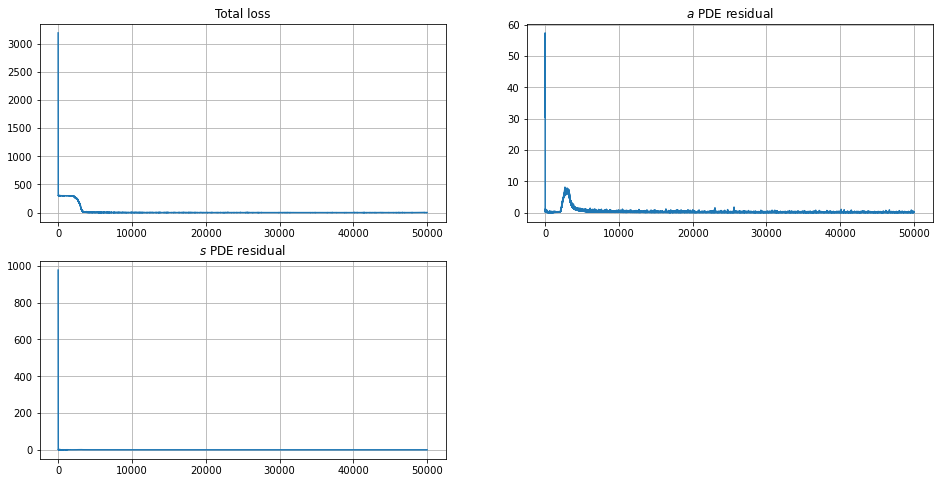

In [5]:
start = 0
end = len(loss)
_ = plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(loss[start:end])
#plt.yscale('log')
plt.title(r"Total loss")
plt.grid()

plt.subplot(2,2,2)
plt.plot(loss_a[start:end])
#plt.yscale('log')
plt.title(r"$a$ PDE residual")
plt.grid()


plt.subplot(2,2,3)
plt.plot(loss_s[start:end])
#plt.yscale('log')
plt.title(r"$s$ PDE residual")
plt.grid()


plt.show()



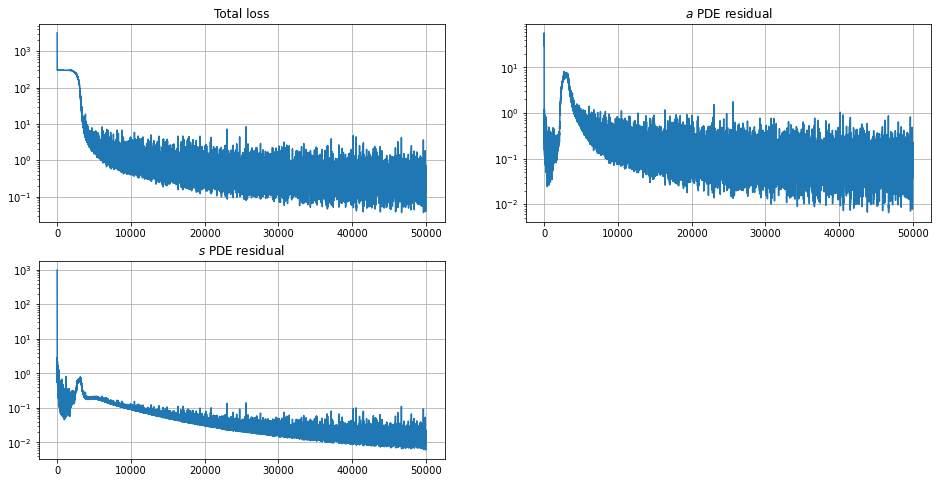

In [6]:
start = 0
end = len(loss)
_ = plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(loss[start:end])
plt.yscale('log')
plt.title(r"Total loss")
plt.grid()

plt.subplot(2,2,2)
plt.plot(loss_a[start:end])
plt.yscale('log')
plt.title(r"$a$ PDE residual")
plt.grid()


plt.subplot(2,2,3)
plt.plot(loss_s[start:end])
plt.yscale('log')
plt.title(r"$s$ PDE residual")
plt.grid()


plt.show()



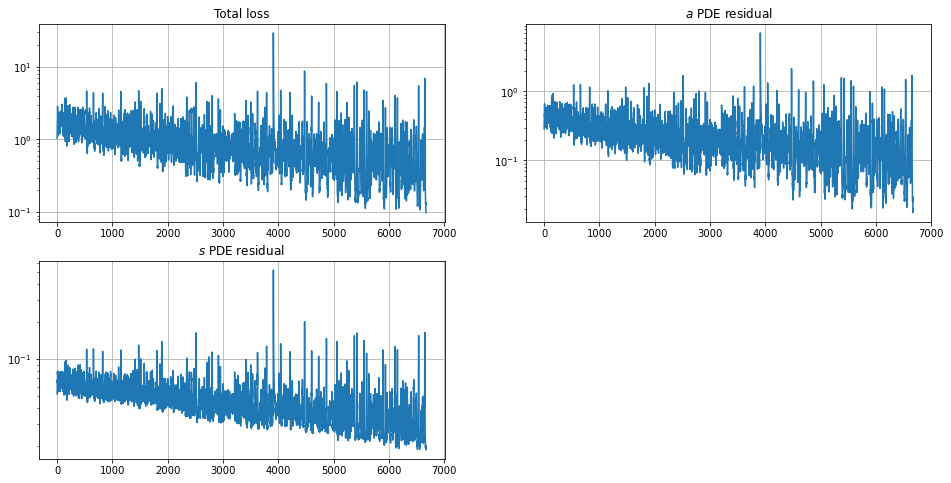

In [8]:
start = 0
end = len(loss)
_ = plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(loss2[start:end])
plt.yscale('log')
plt.title(r"Total loss")
plt.grid()

plt.subplot(2,2,2)
plt.plot(loss_a2[start:end])
plt.yscale('log')
plt.title(r"$a$ PDE residual")
plt.grid()

plt.subplot(2,2,3)
plt.plot(loss_s2[start:end])
plt.yscale('log')
plt.title(r"$s$ PDE residual")
plt.grid()

plt.show()

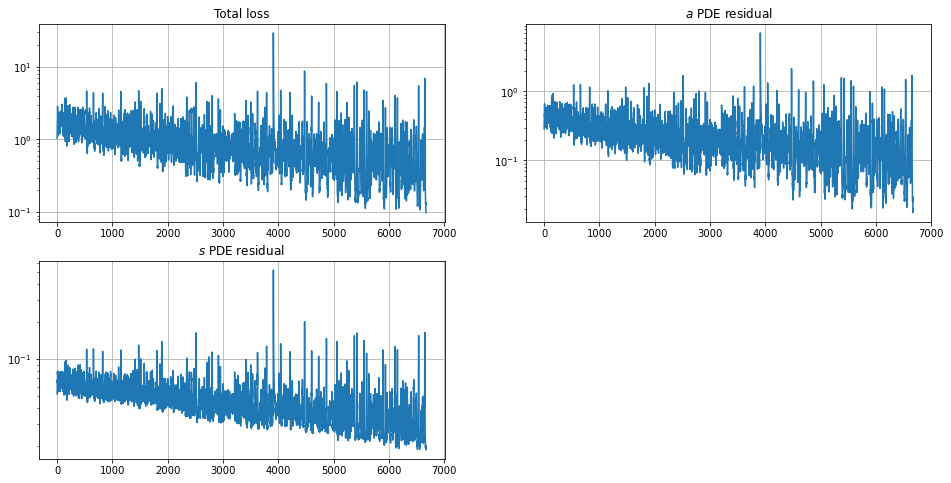

In [9]:
start = 0
end = len(loss2)
_ = plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(loss2[start:end])
plt.yscale('log')
plt.title(r"Total loss")
plt.grid()

plt.subplot(2,2,2)
plt.plot(loss_a2[start:end])
plt.yscale('log')
plt.title(r"$a$ PDE residual")
plt.grid()


plt.subplot(2,2,3)
plt.plot(loss_s2[start:end])
plt.yscale('log')
plt.title(r"$s$ PDE residual")
plt.grid()


plt.show()


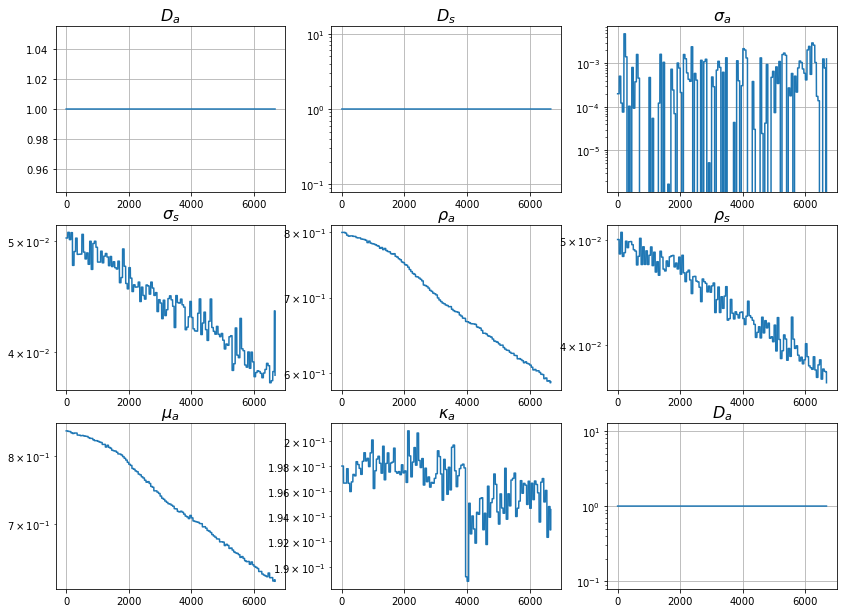

In [10]:
start = 0
end = -1
_ = plt.figure(figsize=(14,14))

plt.subplot(4,3,1)
plt.plot(np.r_[params_estimates2['D_a']])
plt.title(r"$D_a$", fontsize=16)
#plt.yscale('log')
plt.grid()

plt.subplot(4,3,2)
plt.plot(np.r_[params_estimates2['D_s']])
plt.title(r"$D_s$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,3)
plt.plot(np.r_[params_estimates2['sigma_a']])
plt.title(r"$\sigma_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,4)
plt.plot(np.r_[params_estimates2['sigma_s']])
plt.title(r"$\sigma_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.005,.04])
plt.grid()

plt.subplot(4,3,5)
plt.plot(np.r_[params_estimates2['rho_a']])
plt.title(r"$\rho_a$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,6)
plt.plot(np.r_[params_estimates2['rho_s']])
plt.title(r"$\rho_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.0,.05])
plt.grid()


plt.subplot(4,3,7)
plt.plot(np.r_[params_estimates2['mu_a']])
plt.title(r"$\mu_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,8)
plt.plot(np.r_[params_estimates2['kappa_a']])
plt.title(r"$\kappa_a$", fontsize=16)
plt.yscale('log')
#plt.ylim([0,1])
plt.grid()

plt.subplot(4,3,9)
plt.plot(np.r_[params_estimates2['D_a']])
plt.title(r"$D_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.show()

In [6]:
def print_vals(name, value, actual=None):
    def _get_val(item):
        val = item.tolist()
        if type(val) is float:
            return val
        else:
            return val[0]
    value = _get_val(value)
    
    if actual is not None and actual > 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/(actual):0.8f}")
    elif actual is not None and actual == 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f} ")
        
    else:
        print(f"{name}: {value:0.8f}")
    

D_a = model.sess.run(model.D_a)
D_s = model.sess.run(model.D_s)
sigma_s = model.sess.run(model.sigma_s)
rho_s = model.sess.run(model.rho_s)

sigma_a = model.sess.run(model.sigma_a)
rho_a = model.sess.run(model.rho_a)
mu_a = model.sess.run(model.mu_a)
kappa_a = model.sess.run(model.kappa_a)


print_vals("D_s", D_s, 0.2)
print_vals("sigma_s", sigma_s, 0.02)
print_vals("rho_s", rho_s, 0.02)
print()
print_vals("D_a", D_s, 0.005)
print_vals("sigma_a", sigma_a, 0.0)
print_vals("rho_a", rho_a,0.01)
print_vals("mu_a", mu_a, 0.01 )
print_vals("kappa_a", kappa_a, 0.25)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.03820500, actual: 0.020, difference: 0.01820500, relative: %91.02500752
rho_s: 0.03957690, actual: 0.020, difference: 0.01957690, relative: %97.88449630

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.64533943, actual: 0.010, difference: 0.63533943, relative: %6353.39429379
mu_a: 0.68126041, actual: 0.010, difference: 0.67126041, relative: %6712.60406971
kappa_a: 0.20107459, actual: 0.250, difference: 0.04892541, relative: %19.57016587


# Estimated parameters

In [7]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1#-1
t_test = 50000#t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [8]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis]}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 4.45111895
Loss_s : 0.37728977
Loss   : 5.82472610


In [9]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

0.8910128418763796
0.10530465333124214


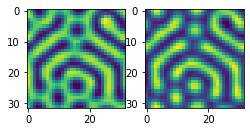

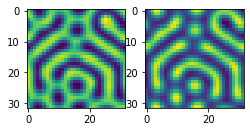

In [10]:

plt.subplot(131)
plt.imshow(a_2)
plt.subplot(132)
plt.imshow(s_2)
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.show()

In [363]:
saver = tf.train.Saver()
saver.save(model.sess, './PINN_Turring_model_loss_full_32_steps', global_step=0)

'./PINN_Turring_model_loss_full_32_steps-0'

In [364]:
print(model.x_tf.name)
print(model.y_tf.name)
print(model.t_tf.name)
print(model.a_pred.name)
print(model.s_pred.name)
print(model.loss_1.name)
print(model.loss_a.name)
print(model.loss_s.name)

x_tf_19:0
y_tf_19:0
t_tf_19:0
a_pred_19:0
s_pred_19:0
add_253:0
loss_a_19:0
loss_s_19:0
